In [1]:
from sea_breeze import load_model_data, sea_breeze_funcs, sea_breeze_filters
from dask.distributed import Client
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46743 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46743/status,
Dashboard: /proxy/46743/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41503,Workers: 7
Dashboard: /proxy/46743/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:46081,Total threads: 2
Dashboard: /proxy/42837/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:40947,


2025-07-21 12:27:30,326 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 44910bda4fde94cb81f5fc938d83d40f initialized by task ('rechunk-transfer-12cb4be76889d8f5f670b48835f5e78b', 0, 0, 0, 0, 0, 0) executed on worker tcp://127.0.0.1:44805
2025-07-21 12:27:31,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 44910bda4fde94cb81f5fc938d83d40f deactivated due to stimulus 'task-finished-1753064851.1572526'


## First define the spatial and temporal bounds for the detection

In [3]:
#Time bounds - a single day
t1 = "2016-01-11 12:00"
t2 = "2016-01-12 12:00"

#Lat lon and height bounds (Tiwi Islands, Australia domain)
lat_slice = slice(-12.5,-10.49)
lon_slice = slice(129.5,132)
hgt_slice = slice(0,4500)

#Set smoothing option to True (gaussian smoothing filter with a sigma of 2. See scipy.ndimage.gaussian_filter)
smooth = True
sigma = 2

## Load model data

* Here we are loading data from AUS2200 (https://dx.doi.org/10.25914/w95d-q328)
* First load the land sea mask, which is used to compute the angle of the coastline and onshore wind component
* Then, u (model levels), v (model levels), uas, vas, hus, and tas
* We also smooth the data with a gaussian filter

In [4]:
#Load land sea mask and compute coastline angles
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino2016",
    lon_slice,
    lat_slice)
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    R=4,
    latlon_chunk_size=8,
    compute=True,
    smooth=smooth,
    sigma=sigma)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

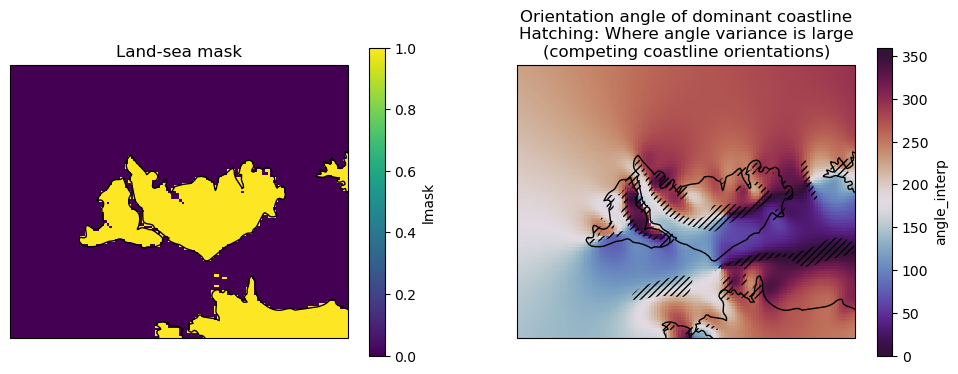

In [5]:
#Plot the model land sea mask and coastline angles
plt.figure(figsize=[12,4])
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
lsm.plot()
ax.coastlines()
plt.title("Land-sea mask")
ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
angle_ds.angle_interp.plot(cmap="twilight_shifted",vmin=0,vmax=360)
xr.plot.contourf(angle_ds.variance_interp,levels=[0.,0.5],hatches=["","/////"],colors="none",add_colorbar=False)
ax.coastlines()
plt.title("Orientation angle of dominant coastline\nHatching: Where angle variance is large\n(competing coastline orientations)");

In [6]:
#Set up the chunks. Because we are smoothing in lat, lon, and height, these need to not be chunked.
#We also interpolate the height data to regular height intervals
chunks = {"lev":{},"time":1,"lat":-1,"lon":-1}

In [7]:
#Load V wind
aus2200_va = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=True),
          "1hr")

#Load U wind
aus2200_ua = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=True),
          "1hr")

#Load surface V wind
aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma),
          "10min")

#Load surface U wind
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma),
          "10min")

#Load surface specific humidity
aus2200_hus = load_model_data.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        smooth=smooth,
        sigma=sigma,
        hgt_slice=slice(0,10)).sel(lev=5)

#Load surface air temperature
aus2200_tas = load_model_data.load_aus2200_variable(
        "ta",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        smooth=smooth,
        sigma=sigma,
        hgt_slice=slice(0,10)).sel(lev=5)

#Load boundary layer depth
aus2200_zmla = load_model_data.round_times(
        load_model_data.load_aus2200_variable(
            "zmla",
            t1,
            t2,
            "mjo-elnino2016",
            lon_slice,
            lat_slice,
            "1hr",
            chunks=chunks,
            staggered="time",
            smooth=smooth,
        sigma=sigma),
              "1hr")

#Make sure everything is hourly (consistent with ua and va)
aus2200_tas = aus2200_tas.sel(time=aus2200_tas.time.dt.minute==0)
aus2200_hus = aus2200_hus.sel(time=aus2200_hus.time.dt.minute==0)
aus2200_vas = aus2200_vas.sel(time=aus2200_vas.time.dt.minute==0)
aus2200_uas = aus2200_uas.sel(time=aus2200_uas.time.dt.minute==0)    

## Sea breeze functions

Compute three diagnostics of sea breezes
* Sea breeze (circulation) index (Hallgren et al. 2023), SBI
* 2d kinematic moisture frontogenesis, F 
* Fuzzy algorithm based on time rate of change (Coceal et al. 2018)

In [8]:
#Sea breeze index
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})
sbi = sea_breeze_funcs.calc_sbi(aus2200_wind,
                            angle_ds.angle_interp,
                            subtract_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            vert_coord="height")

In [9]:
#Moisture frontogenesis
F = sea_breeze_funcs.kinematic_frontogenesis(
        aus2200_hus,
        aus2200_uas,
        aus2200_vas
    ) 

In [10]:
#Fuzzy algorithm

#Calculate hourly rate of change
F_hourly = sea_breeze_funcs.hourly_change(
    aus2200_hus,
    aus2200_tas,
    aus2200_uas,
    aus2200_vas,
    angle_ds.angle_interp
)    

#Combine into "fuzzy function"
F_fuzzy = field = sea_breeze_funcs.fuzzy_function_combine(
    F_hourly.wind_change,
    F_hourly.q_change,
    F_hourly.t_change, combine_method="mean")

### Plot each of the sea breeze diagnostics for a single time step

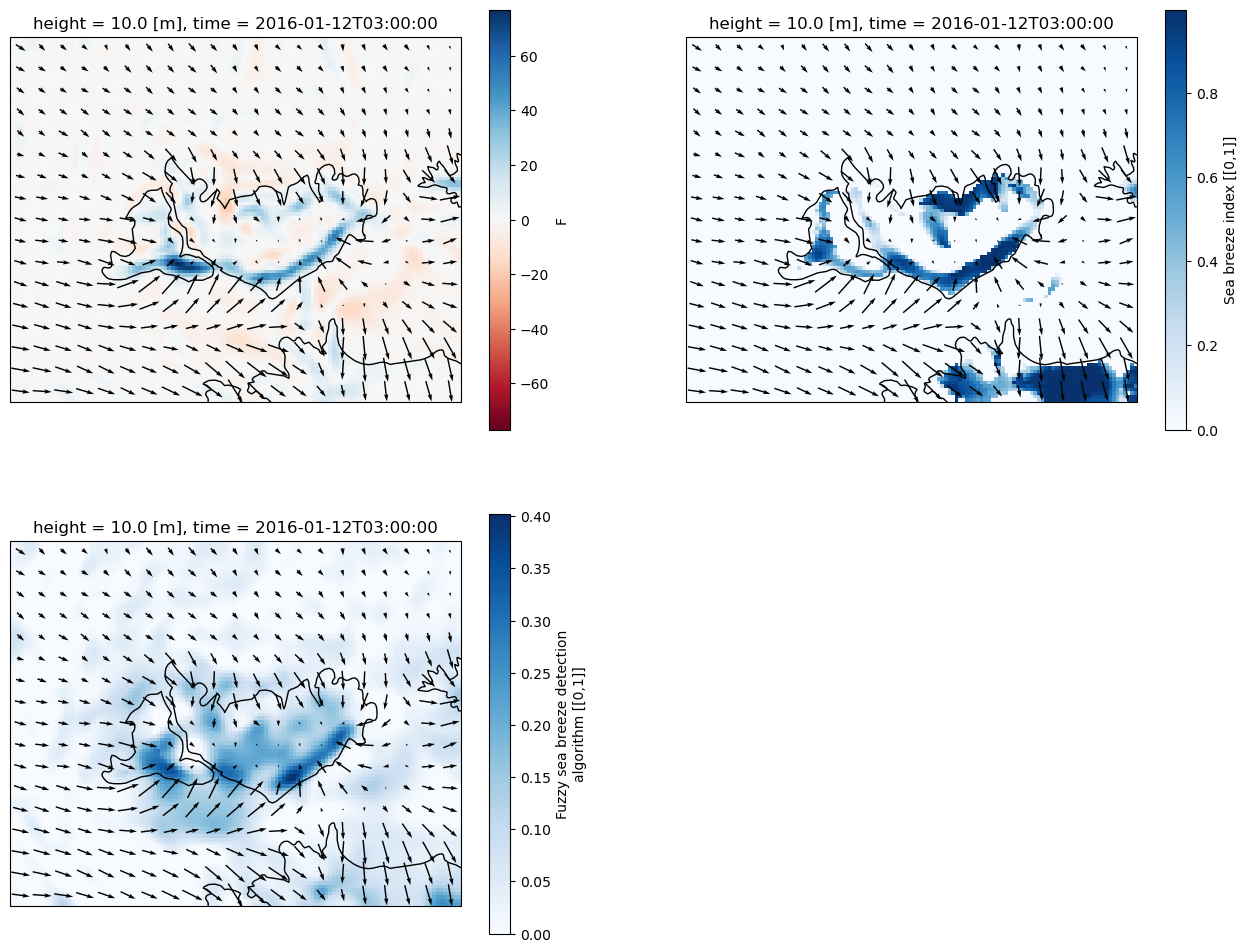

In [11]:
t = "2016-01-12 03:00"

plt.figure(figsize=[16,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
F.sel(time=t).F.plot(cmap="RdBu")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
sbi.sel(time=t).sbi.plot(cmap="Blues")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
F_fuzzy.sel(time=t).plot(cmap="Blues")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

Each of the diagnostics have elevated values along the coastline indicating a potential sea breeze. For some diagnostics (e.g. the fuzzy function) there are also elevated values offshore that are probably not sea breezes, hopefully these will be removed in the subsequent filtering steps.

Note that positive values for frontogenesis represent where a moisture gradient is intensifying due to the flow. The SBI and fuzzy functions range from 0 to 1, with values closer to 1 representing more sea breeze-like conditions. For the SBI, higher values are indicated when the low level flow is more perpendicular to the coasline, and the upper level flow is directly opposing it. For the fuzzy algorithm, higher values indicate a larger rate of change in onshore flow, moisture and temperature.

## Sea breeze filters

* Now identify sea breeze objects in each of the diagnostics
* Each function is transformed into a binary mask using a percentile value as a threshold over the entire spatial-temporal domain (here, 99th percentile between t1 and t2)
* Several conditions can be applied to filter out non sea breeze objects (see kwargs and filter_3d docstring)

For the filter_3d function, this assumes that the diagnostic is chunked only in time with a chunk size of 1 (as it uses xr.map_blocks). See filter_2d for the 2d version

In [12]:
#Load the sea breeze functions into memory as we use all time steps to define the masking threshold
sbi = sbi.persist()
F_fuzzy = F_fuzzy.persist()
F = F.persist()

In [13]:
#Set up filtering options. Here just use the orientation and area filters
kwargs = {
    "orientation_filter":False,
    "aspect_filter":False,
    "area_filter":True,        
    "land_sea_temperature_filter":False,                    
    "temperature_change_filter":False,
    "humidity_change_filter":False,
    "wind_change_filter":False,
    "propagation_speed_filter":False,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    }

#Set the percentile threshold
p = 99.0

#For the propagation speed filter, we also need to provide vprime (the onshore wind component)
uprime, vprime = sea_breeze_funcs.rotate_wind(
    aus2200_uas,
    aus2200_vas,
    angle_ds["angle_interp"])

#Do the filtering
filters = []
for field in [F.F, sbi.sbi, F_fuzzy]:
    filters.append(
        sea_breeze_filters.filter_3d(
        field,
        hourly_change_ds=F_hourly,
        ta=aus2200_tas,
        lsm=lsm,
        angle_ds=angle_ds,
        vprime=vprime.drop("height"),
        p=p,
        save_mask=False,
        filter_out_path=None,
        skipna=False,
        props_df_out_path="out.csv",
        **kwargs)
    )

INFO: Computing 99.0th percentile from field...
Using threshold:  [28.24337835]
INFO: Computing 99.0th percentile from field...
Using threshold:  [0.46544719]
INFO: Computing 99.0th percentile from field...
Using threshold:  [0.27481427]


Text(0.5, 1.0, 'Sea breeze objects from the\nhourly rate of change (fuzzy) method')

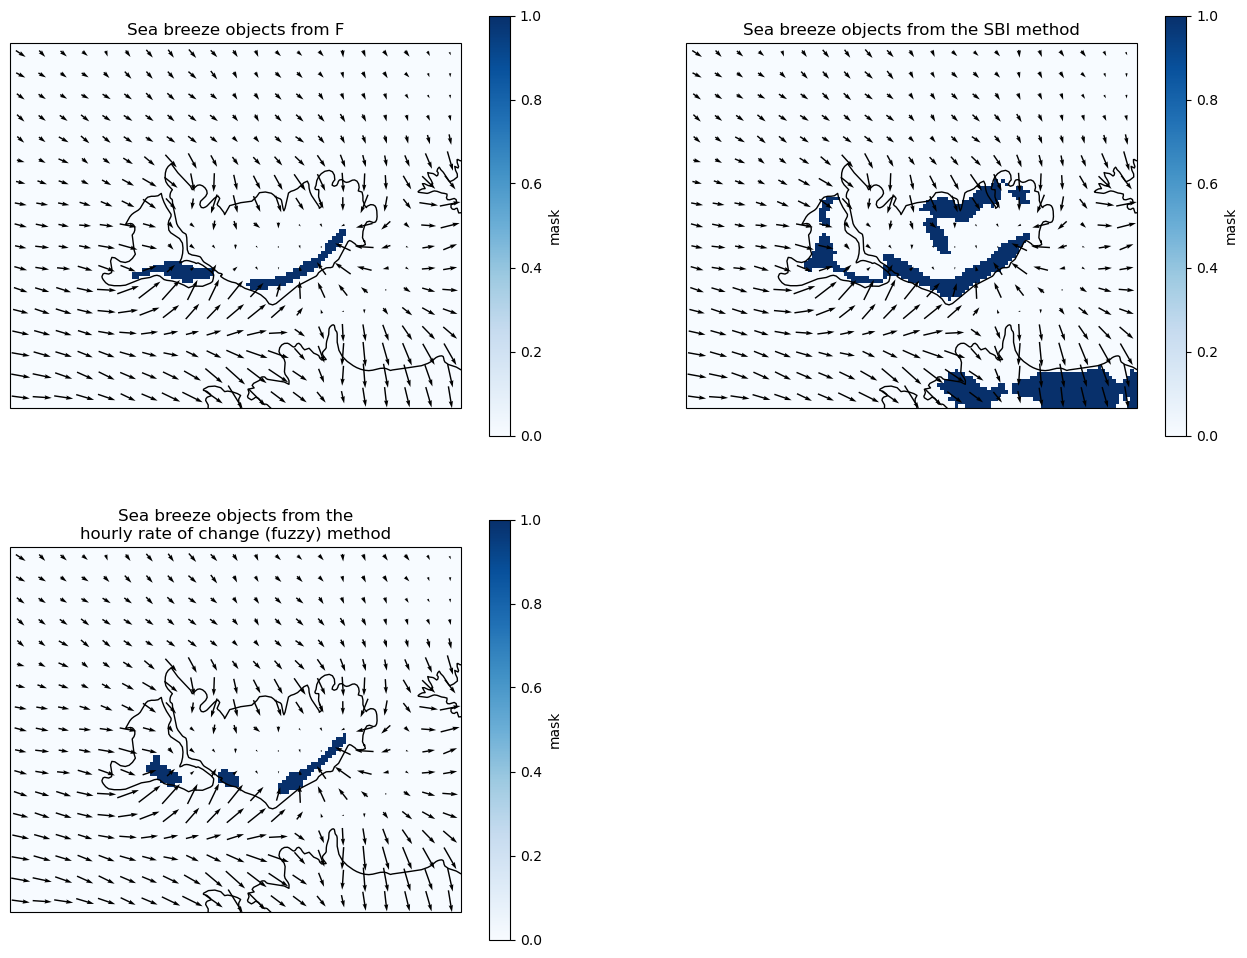

In [14]:
logging.getLogger("flox").setLevel(logging.WARNING)

plt.figure(figsize=[16,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
filters[0].mask.sel(time=t).plot(cmap="Blues")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("Sea breeze objects from F")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
filters[1].mask.sel(time=t).plot(cmap="Blues")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("Sea breeze objects from the SBI method")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
filters[2].mask.sel(time=t).plot(cmap="Blues")
xr.Dataset({"u":aus2200_uas,"v":aus2200_vas}).sel(time=t).coarsen({"lat":6,"lon":6},boundary="trim").mean().\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("Sea breeze objects from the\nhourly rate of change (fuzzy) method")

